# Physics informed neural networks

In this notebook we will use [Jaxfun](https://github.com/spectralDNS/jaxfun) together with

* [Jax](https://docs.jax.dev/en/latest/index.html)
* [Optax](https://optax.readthedocs.io/en/latest/)
* [Flax](https://github.com/google/flax)

in order to solve a differential equation using the least squares minimization formulation of the problem. We will use basis functions based on regular multi layer perceptrons as well as spectral expansions in orthogonal polynomials.

The ubiquitous linear Helmholtz equation is defined as

$$
u^{''}(x) + \alpha u(x) = f(x), \quad x \in (-1, 1), \, \alpha \in \mathbb{R^+}
$$

and in this notebook it will be used with boundary conditions $u(-1)=u(1)=0$. The function $u(x)$ represents the unknown solution and the right hand side function $f(x)$ is continuous and known. We can define a residual $\mathcal{R}u(x)$ for the Helmholtz equation as

$$
\mathcal{R}u(x) = u^{''}(x) + \alpha u(x) - f(x),
$$

which should be zero for any point in the domain. In this notebook we will approximate $u(x)$ with a neural network $u_{\theta}(x)$, where $\theta \in \mathbb{R}^M$ represents the unknown weights of the network. In order to find $u_{\theta}(x)$ we will attempt to force the residual $\mathcal{R}u_{\theta}(x_i)$ to zero in a least squares sense for some $N$ chosen training points $\{x_i\}_{i=0}^{N-1}$. To this end the least squares problem reads

\begin{equation*}
\underset{\theta \in \mathbb{R}^M}{\text{minimize}}\, L(\theta):=\frac{1}{N}\sum_{i=0}^{N-1} \mathcal{R}u_{\theta}(x_i; \theta)^2 + \frac{1}{2} \left(u_{\theta}(-1; \theta)^2 + u_{\theta}(1; \theta)^2 \right)
\end{equation*}

We start by importing necessary functionality from both [jax](https://docs.jax.dev/en/latest/index.html), [optax](https://optax.readthedocs.io/en/latest/), [flax](https://github.com/google/flax) and Jaxfun. We also make use of Sympy in order to describe the equations.

In [1]:
# ruff: noqa: E402
import jax

jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import matplotlib.pyplot as plt
import sympy as sp
from flax import nnx

from jaxfun.operators import Div, Grad
from jaxfun.pinns import FlaxFunction, Loss, MLPSpace
from jaxfun.pinns.optimizer import GaussNewton, Trainer, adam, lbfgs
from jaxfun.utils.common import lambdify, ulp

Notice the `MLPSpace` class, which represents a functionspace for a regular multilayer perceptron. The space will make use of a subclass of the [flax](https://flax.readthedocs.io/en/latest) [nnx.Module](https://flax.readthedocs.io/en/latest/api_reference/flax.nnx/module.html#module-flax.nnx). 

We create this space holds information about the input, output and hidden layers in the neural network. Here we create an MLP for a one-dimensional problem (one input variable) and 16 neurons for a single hidden layer. 

In [2]:
V = MLPSpace([16], dims=1, name="V")

It is possible to use several hidden layers, for example by choosing `V = MLPSpace([8, 8, 8], dims=1)`.

The MLP function space is subsequently used to create a trial function for the neural network. The function `v` below holds all the unknown weights in the MLP.

In [3]:
v = FlaxFunction(
    V,
    rngs=nnx.Rngs(1001),
    name="v",
    fun_str="phi",
    kernel_init=nnx.initializers.xavier_uniform(),
)

Inside `v`, the regular flax nnx module is accessible through `v.module`. 

We will test the solver using a known manufactured solution. We can use any solution, but it should be continuous and the solution needs to use the same symbols as Jaxfun. Below we choose a mixture of a second order polynomial (to get the correct boundary condition) an exponential and a cosine function. This function is continuous, but it requires quite a few unknowns in order to get a decent solution.

In [4]:
x = V.system.x
ue = (1 - x**2) * sp.exp(sp.cos(2 * sp.pi * x))

The equation to solve is now described in strong form using the residual $\mathcal{R}u_{\theta}$. Note that we create the right hand side function $f(x)$ from the manufactured solution.

In [5]:
alpha = 1
f = Div(Grad(ue)) + alpha * ue
residual = Div(Grad(v)) + alpha * v - f

The two operators [Div](https://github.com/spectralDNS/jaxfun/blob/main/jaxfun/operators.py) and [Grad](https://github.com/spectralDNS/jaxfun/blob/main/jaxfun/operators.py) are defined in Jaxfun. For a 1D problem on the straight line there is no difference from writing the residual simply as 

residual = sp.diff(v, x, 2) + alpha * v - (sp.diff(ue, x, 2) + alpha*ue)

We can look at the residual in code:

In [6]:
residual

v(x; V) - ((1 - x**2)*exp(cos(2*x*pi)) + Div(Grad((1 - x**2)*exp(cos(2*x*pi))))) + Div(Grad(v(x; V)))

Note that $\nabla \cdot$ represents divergence and $\nabla v$ represents the gradient of the scalar field $v$. The neural network function $v$ is written as $v(x; V)$ since $v$ is a function of $x$ and it is a basis function on the space $V$. The residual above is in unevaluated form. We can evaluate it using the Sympy function `doit`:

In [7]:
residual.doit()

-8*x*pi*exp(cos(2*x*pi))*sin(2*x*pi) - 4*pi**2*(1 - x**2)*exp(cos(2*x*pi))*sin(2*x*pi)**2 + 4*pi**2*(1 - x**2)*exp(cos(2*x*pi))*cos(2*x*pi) - (1 - x**2)*exp(cos(2*x*pi)) + phi(x) + 2*exp(cos(2*x*pi)) + Derivative(phi(x), (x, 2))

Note that Sympy here evaluates derivatives to the best of its abilities, and the neural network function $v$ has been replaced by the expression $\phi(x)$. This is because `phi` is set as `fun_str` for the created `FlaxFunction` `v`.

We need training points inside the domain in order to solve the least squares problem. Create random points `xj` using the helper class `Line` and an array `xb` that holds the coordinates of the two boundaries. Note that the argument to `mesh.get_points` is the total number of points in the mesh, including boundary points. Since it's a 1D mesh, the number of boundary points is 2.

In [8]:
from jaxfun.pinns.mesh import Line

mesh = Line(-1, 1, key=jax.random.PRNGKey(2002))
xj = mesh.get_points(1200, domain="inside", kind="random")
xb = mesh.get_points(1200, domain="boundary")

In [9]:
xb

Array([[-1.],
       [ 1.]], dtype=float64)

We have two coupled problems to solve: The equation defined by `residual` and the boundary conditions. In order to solve these problems we now make use of the `Loss` class and a feed the two problems to it. We also need to feed the correct collocation points to each problem:

In [10]:
loss_fn = Loss((residual, xj), (v, xb))
loss_fn.residuals

The first residual represents the equation to solve. It contains two subequations representing $v''$ and $\alpha v$, wheras the constant part of the equation is placed in the target (an array of shape $N-2$). 

In [11]:
loss_fn.residuals[0].eqs

(functools.partial(<function _lookup_or_eval at 0x129bb5ee0>, mod_id=-7248477791155091496, global_index=0, k=2, variables=(x, x)),
 functools.partial(<function _lookup_or_eval at 0x129bb5ee0>, mod_id=-7248477791155091496, global_index=0, k=0, variables=()))

In [12]:
loss_fn.residuals[0].target.shape

(1198,)

As such each `Residual` is a class holding the required functions in order to compute the residuals. The first one computes $\mathcal{R}u_{\theta}(x)$ and the other the boundary terms $u_{\theta}(-1)+u_{\theta}(1)$. Calling `loss_fn(v.module)` returns 

$$
\frac{1}{N-2}\sum_{i=0}^{N-3} \mathcal{R}u_{\theta}(x_i; \theta)^2 + \frac{1}{2} \left(u_{\theta}(-1; \theta)^2 + u_{\theta}(1; \theta)^2 \right)
$$

In order to solve the least squares problem we need an optimizer. Any `optax` optimizer may be used, but we will start with Adam, and then switch to a more accurate optimizer after a while. We first run 5000 epochs with Adam

In [13]:
trainer = Trainer(loss_fn)
opt_adam = adam(v.module, learning_rate=1e-3)
trainer.train(opt_adam, 5000, epoch_print=1000)

Running optimizer Adam(lr=0.001)
Epoch 1000 Adam, loss: 24.212679689026828
Epoch 2000 Adam, loss: 10.929783407181848
Epoch 3000 Adam, loss: 7.584079759056792
Epoch 4000 Adam, loss: 6.555243941387198
Epoch 5000 Adam, loss: 0.39282907943795653


The Adam optimizer is good at eliminating local minima and as such it is good at finding a solution that is close to the global minimum. However, Adam is only first order and not able to find a very accurate solution. For this we need either a quasi-Newton or a Newton optimizer. We start with the limited-memory BFGS optimizer and take 10000 more epochs.

In [14]:
opt_lbfgs = lbfgs(v.module, memory_size=20)
trainer.train(opt_lbfgs, 10000, epoch_print=1000)

Running optimizer LBFGS(memory_size=20)
Epoch 1000 LBFGS, loss: 0.0021036534381027763
Epoch 2000 LBFGS, loss: 0.0006929252781826833
Epoch 3000 LBFGS, loss: 0.0002688397540434463
Epoch 4000 LBFGS, loss: 0.00017680820230148612
Epoch 5000 LBFGS, loss: 0.0001376728182481704
Epoch 6000 LBFGS, loss: 7.967550898411011e-05
Epoch 7000 LBFGS, loss: 4.4536389961001534e-05
Epoch 8000 LBFGS, loss: 3.9558572471689813e-05
Epoch 9000 LBFGS, loss: 3.716767595725918e-05
Epoch 10000 LBFGS, loss: 3.5671176189884986e-05


It is possible to run even more BFGS epoch to further polish this root. However, we will in the end switch to an even more accurate Newton optimizer. Since the Newton optimizer is costly, we run only 10 epochs. The Newton optimizer should only be used when the residual is already close to zero.

In [15]:
opt_hess = GaussNewton(v.module, use_lstsq=False, cg_max_iter=500)
trainer.train(opt_hess, 10, epoch_print=1)

Running optimizer Hessian(lstsq=False)
Epoch 1 Hessian, loss: 3.567051776593697e-05
Epoch 2 Hessian, loss: 3.547246627872606e-05
Epoch 3 Hessian, loss: 3.536297077482187e-05
Epoch 4 Hessian, loss: 3.483442479660281e-05
Epoch 5 Hessian, loss: 3.47923801269713e-05
Epoch 6 Hessian, loss: 3.4554336697808565e-05
Epoch 7 Hessian, loss: 3.411278937691593e-05
Epoch 8 Hessian, loss: 3.406043718920383e-05
Epoch 9 Hessian, loss: 3.360359635773215e-05
Epoch 10 Hessian, loss: 3.357758286007827e-05


Running even more epochs the solution will become even more accurate.

We can now compute the $L^2$ error norm by comparing to the exact solution

In [16]:
uej = lambdify(x, ue)(xj)  # Exact
print("Error", jnp.linalg.norm(v.module(xj) - uej) / jnp.sqrt(len(xj)))

Error 0.0003211560266328185


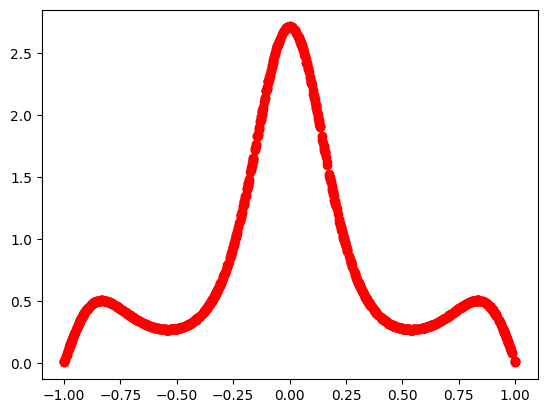

In [17]:
plt.plot(xj, v.module(xj), "b*", xj, uej, "ro");

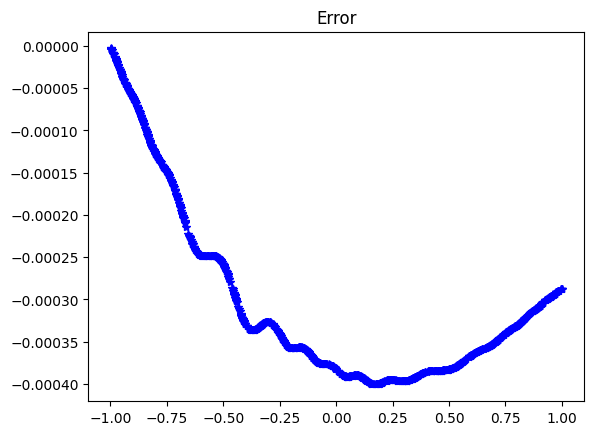

In [18]:
plt.plot(xj, v.module(xj) - uej, "b*")
plt.title("Error");

The residuals of each problem may also be computed using the `loss_fn` class. The residuals for the two boundary conditions are

In [19]:
loss_fn.compute_residual_i(v.module, 1)

Array([-1.97649537e-06, -2.87286025e-04], dtype=float64)

# Spectral least squares solver

The neural network is capturing the solution quite well, but the convergence is quite slow. We know that a problem like the Helmholtz equation with a continuous solution should be very well captured using Legendre or Chebyshev basis functions, that have much better approximation properties than the neural network. Using Jaxfun we can solve this problem with the Galerkin method, but we can also use the least squares formulation similar to as above. 

The solver below is using simply

$$
u_{\theta}(x) = \sum_{i=0}^{N-1} \hat{u}_i L_i(x)
$$

where $L_i(x)$ is the i'th Legendre polynomial and $\hat{u}_i$ are the unknowns.

The least squares implementation goes as follows:

In [20]:
from jaxfun.galerkin.Legendre import Legendre

VN = Legendre(60)
v = FlaxFunction(
    VN, rngs=nnx.Rngs(1001), kernel_init=nnx.initializers.xavier_uniform(), name="v"
)
# We can set up the least squares problem as below
res = Div(Grad(v)) + alpha * v - (Div(Grad(ue)) + alpha * ue)
loss_fn = Loss((res, xj), (v, xb))
trainer = Trainer(loss_fn)
opt_adam = adam(v.module)
trainer.train(opt_adam, 5000, epoch_print=1000)
opt_lbfgs = lbfgs(v.module)
trainer.train(opt_lbfgs, 1000, epoch_print=100)
opt_hess = GaussNewton(v.module, use_lstsq=False, cg_max_iter=500)
trainer.train(opt_hess, 10, epoch_print=1, abs_limit_loss=ulp(1))

Running optimizer Adam(lr=0.001)
Epoch 1000 Adam, loss: 728.8860007016891
Epoch 2000 Adam, loss: 403.207265419468
Epoch 3000 Adam, loss: 205.69120016999793
Epoch 4000 Adam, loss: 105.19858129854185
Epoch 5000 Adam, loss: 55.72996508190343
Running optimizer LBFGS(memory_size=10)
Epoch 100 LBFGS, loss: 44.0059593561843
Epoch 200 LBFGS, loss: 36.48802957972322
Epoch 300 LBFGS, loss: 30.048245022657415
Epoch 400 LBFGS, loss: 27.43722158228511
Epoch 500 LBFGS, loss: 24.901470257481623
Epoch 600 LBFGS, loss: 23.72499451258423
Epoch 700 LBFGS, loss: 22.658972360518476
Epoch 800 LBFGS, loss: 20.939084030387463
Epoch 900 LBFGS, loss: 19.69423857995228
Epoch 1000 LBFGS, loss: 18.326135324986645
Running optimizer Hessian(lstsq=False)
Epoch 1 Hessian, loss: 18.308742105111833
Epoch 2 Hessian, loss: 3.532005967898479e-05
Epoch 3 Hessian, loss: 1.0878068841364633e-10
Epoch 4 Hessian, loss: 1.087806800954237e-10
Epoch 5 Hessian, loss: 1.0878068007799773e-10
Epoch 6 Hessian, loss: 1.0878068012436539e-

Note that with only 3 Newton iterations the error plunges to zero. Comparing now with the exact solution we get a very accurate $L^2$ error

In [21]:
print(
    "Error",
    jnp.linalg.norm(v.module(xj) - uej) / jnp.sqrt(len(xj)),
)

Error 9.55699444686542e-08


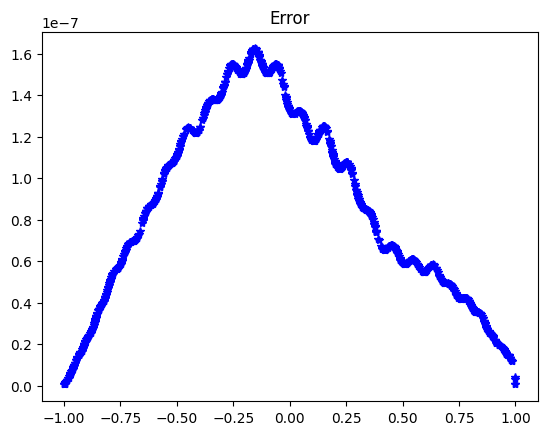

In [22]:
plt.plot(xj, v.module(xj) - uej, "b*")
plt.title("Error");

# Implicit spectral least squares

In [23]:
from jaxfun.galerkin import FunctionSpace, TestFunction, TrialFunction, inner

D = FunctionSpace(
    60, Legendre, bcs={"left": {"D": 0}, "right": {"D": 0}}, name="D", fun_str="psi"
)
v = TestFunction(D, name="v")
u = TrialFunction(D, name="u")

A, L = inner(
    # v * (Div(Grad(u)) + alpha * u) - v * (Div(Grad(ue)) + alpha * ue), # Galerkin
    (Div(Grad(v)) + alpha * v) * (Div(Grad(u)) + alpha * u)
    - (Div(Grad(v)) + alpha * v) * (Div(Grad(ue)) + alpha * ue),  # LSQ
    sparse=True,
    sparse_tol=1000,
    return_all_items=False,
)

uh = jnp.linalg.solve(A.todense(), L)
uj = D.evaluate(xj, uh)
uej = lambdify(x, ue)(xj)
error = jnp.linalg.norm(uj - uej) / jnp.sqrt(len(xj))
print(error)

2.5695308350948073e-09


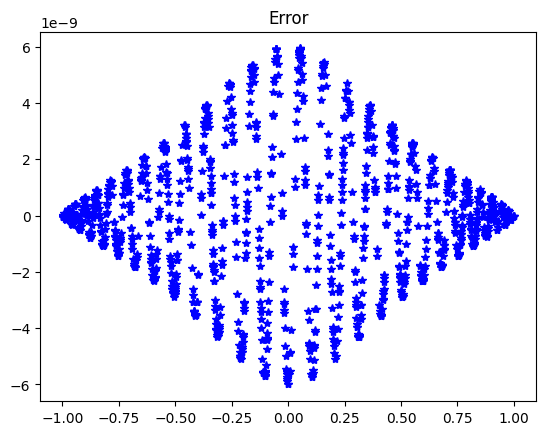

In [24]:
plt.plot(xj, uj - uej, "b*")
plt.title("Error");

The solution with implicit Galerkin or least squares is about as accurate as the regular least squares.